In [1]:
# Cell 1
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import time 



CSV_PATH = '/cluster/home/miolate21/FER_biasmitigation1/results/attributes_npy48.csv'

DATA_DIR = None


IMG_HEIGHT = 48
IMG_WIDTH = 48
IMG_CHANNELS = 1 

# Training config
BATCH_SIZE = 64
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE 


np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# Cell 2

print(f"Loading CSV from: {CSV_PATH}")
try:
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV file not found at {CSV_PATH}")

    df = pd.read_csv(CSV_PATH)

    # Drop extra column if it snuck in
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    print(f"Loaded {len(df)} rows from the CSV.")

except FileNotFoundError as e:
    print(f"File not found: {e}")
    df = pd.DataFrame()
except Exception as e:
    print(f"Problem loading the CSV: {e}")
    df = pd.DataFrame()

if not df.empty:
    required_columns = ['image_path', 'emotion']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Missing required columns. Make sure the CSV includes: {required_columns}")

    emotion_labels = sorted(df['emotion'].unique())

    if not all(isinstance(label, str) for label in emotion_labels):
        print("Double check CSV.")

    # Build label maps
    emotion_to_idx = {label: idx for idx, label in enumerate(emotion_labels)}
    idx_to_emotion = {idx: label for label, idx in emotion_to_idx.items()}

    df['label'] = df['emotion'].map(emotion_to_idx)

    if df['label'].isnull().any():
        print("Error.")
        print(df[df['label'].isnull()])

    print("\nLabel map:")
    print(emotion_to_idx)
    print("\nFirst few rows:")
    print(df.head())
else:
    print("CSV couldn’t be loaded — skipping label mapping.")

Loading CSV from: /cluster/home/miolate21/FER_biasmitigation1/results/attributes_npy48.csv
Loaded 41478 rows from the CSV.

Label map:
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

First few rows:
                                          image_path emotion dominant_race  \
0  /cluster/home/miolate21/FER_biasmitigation1/da...   happy         white   
1  /cluster/home/miolate21/FER_biasmitigation1/da...   happy         white   
2  /cluster/home/miolate21/FER_biasmitigation1/da...   happy         white   
3  /cluster/home/miolate21/FER_biasmitigation1/da...   happy         white   
4  /cluster/home/miolate21/FER_biasmitigation1/da...   happy         white   

  status  label  
0     OK      3  
1     OK      3  
2     OK      3  
3     OK      3  
4     OK      3  


In [3]:
# Cell 3 

if not df.empty:
    path_column_to_check = 'image_path'
    print(f"\nChecking if .npy files listed in '{path_column_to_check}' exist...")

    start_time = time.time()
    exists = df[path_column_to_check].apply(os.path.exists)
    end_time = time.time()
    print(f"Check finished in {end_time - start_time:.2f} seconds.")

    num_missing = len(df) - exists.sum()
    if num_missing > 0:
        print(f"\n{num_missing} files listed in the CSV were not found.")
        missing_files_df = df[~exists]
        print("Example missing file paths (first 5):")
        print(missing_files_df[path_column_to_check].head().to_list())

        # Drop entries for missing files
        print(f"Dropping {num_missing} records from the DataFrame.")
        original_count = len(df)
        df = df[exists].copy()
        print(f"DataFrame size changed from {original_count} to {len(df)}.")

    # Show updated head if changes occurred
    if num_missing > 0:
        print("\nUpdated DataFrame preview:")
        print(df.head())

else:
    print("No data to check — skipping file existence step.")


Checking if .npy files listed in 'image_path' exist...
Check finished in 7.89 seconds.


In [4]:
# Cell 4 Train/Validation Split

if not df.empty:
    if 'label' not in df.columns:
        raise KeyError("Missing 'label' column.")

    label_counts = df['label'].value_counts()

    print("\nSplitting data into training and validation sets...")
    try:
        train_df, val_df = train_test_split(
            df,
            test_size=0.2,
            stratify=df['label'],
            random_state=SEED
        )

        print(f"Train set: {len(train_df)} samples")
        print(f"Validation set: {len(val_df)} samples")

        # Optional: check label balance
        print("\nTrain label distribution (%):")
        print(train_df['emotion'].value_counts(normalize=True).sort_index() * 100)
        print("\nValidation label distribution (%):")
        print(val_df['emotion'].value_counts(normalize=True).sort_index() * 100)

    except ValueError as e:
        print(f"\nSplit failed: {e}")
        print("This might be due to uneven label distribution. Try adjusting classes or using a non-stratified split.")
        train_df, val_df = pd.DataFrame(), pd.DataFrame()

else:
    print("DataFrame is empty — skipping train/val split.")
    train_df, val_df = pd.DataFrame(), pd.DataFrame()


Splitting data into training and validation sets...
Train set: 33182 samples
Validation set: 8296 samples

Train label distribution (%):
emotion
angry       11.415828
disgust      2.896149
fear        10.605147
happy       29.027786
neutral     18.672774
sad         16.469773
surprise    10.912543
Name: proportion, dtype: float64

Validation label distribution (%):
emotion
angry       11.415140
disgust      2.892960
fear        10.607522
happy       29.026037
neutral     18.671649
sad         16.477821
surprise    10.908872
Name: proportion, dtype: float64


In [5]:
# Cell 5

IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(f"Expected image shape: {IMAGE_SHAPE}")

def _load_npy_py(path_bytes, label_int):
    path_str = path_bytes.numpy().decode('utf-8')
    try:
        npy = np.load(path_str)
        npy = npy.astype(np.float32)
        
        # --- Handle different shapes ---
        if npy.shape == IMAGE_SHAPE[:2]:  # (224, 224)
            npy = np.expand_dims(npy, axis=-1)  # Make it (224, 224, 1)
        elif npy.shape != IMAGE_SHAPE:  # Not (224, 224, 1)
            raise ValueError(f"Unexpected shape {npy.shape} for image {path_str}")
        
        return npy, np.int32(label_int)

    except FileNotFoundError:
        print(f"ERROR (_load_npy_py): File not found: {path_str}. Returning zeros.")
        return np.zeros(IMAGE_SHAPE, dtype=np.float32), np.int32(label_int)

    except Exception as e:
        print(f"Error loading or processing {path_str}: {e}")
        return np.zeros(IMAGE_SHAPE, dtype=np.float32), np.int32(label_int)

@tf.function
def load_npy_tf(path_tensor, label_tensor):
    image, label = tf.py_function(
        _load_npy_py,
        inp=[path_tensor, label_tensor],
        Tout=(tf.float32, tf.int32)
    )
    image.set_shape(IMAGE_SHAPE)
    label.set_shape(())  # Label is a scalar
    return image, label

def build_dataset(df_subset, shuffle=True, batch_size=BATCH_SIZE):
    if df_subset.empty:
        return tf.data.Dataset.from_tensor_slices(
            (tf.constant([], dtype=tf.string), tf.constant([], dtype=tf.int32))
        ).map(load_npy_tf, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)


    paths = df_subset['image_path'].values
    labels = df_subset['label'].values.astype(np.int32) 

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if shuffle:
        buffer_size = len(df_subset)
        ds = ds.shuffle(buffer_size=buffer_size, seed=SEED, reshuffle_each_iteration=True)

    ds = ds.map(load_npy_tf, num_parallel_calls=AUTOTUNE)
    ds = ds.repeat()

    ds = ds.batch(batch_size, drop_remainder=False)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    print(f"Built dataset with shuffle={shuffle}. Element spec: {ds.element_spec}")
    return ds

print("Dataset builder functions defined.")

Expected image shape: (48, 48, 1)
Dataset builder functions defined.


In [6]:
# Cell 6: Create Train and Validation Datasets

train_ds = None
val_ds = None

if not train_df.empty and not val_df.empty:
    print("Building training dataset...")
    train_ds = build_dataset(train_df, shuffle=True, batch_size=BATCH_SIZE)

    print("\nBuilding validation dataset...")
    val_ds = build_dataset(val_df, shuffle=False, batch_size=BATCH_SIZE)

    print("\nTrain and validation tf.data.Dataset objects created.")
   
elif train_df.empty:
     print("Skipping dataset creation: Training DataFrame is empty.")
elif val_df.empty:
     print("Skipping dataset creation: Validation DataFrame is empty.")
else:
     print("Skipping dataset creation: Both DataFrames are empty.")

Building training dataset...
Built dataset with shuffle=True. Element spec: (TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Building validation dataset...
Built dataset with shuffle=False. Element spec: (TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Train and validation tf.data.Dataset objects created.


In [7]:
# Cell 7: Test the Pipeline

print("\n--- Testing Data Pipeline ---")

if train_ds is not None:
    print("\nChecking a batch from the training dataset:")
    try:
        for images_batch, labels_batch in train_ds.take(1).as_numpy_iterator():
            print(f"  Image batch shape: {images_batch.shape}")
            print(f"  Label batch shape: {labels_batch.shape}")
            print(f"  Image dtype: {images_batch.dtype}")
            print(f"  Label dtype: {labels_batch.dtype}")
            print(f"  Pixel value range: min={np.min(images_batch):.4f}, max={np.max(images_batch):.4f}")
            print(f"  Sample labels: {labels_batch[:10]}")

            if 'idx_to_emotion' in globals() and len(labels_batch) > 0:
                decoded = [idx_to_emotion.get(lbl, 'Unknown') for lbl in labels_batch[:5]]
                print(f"  Decoded labels: {decoded}")

    except Exception as e:
        print(f"Problem while reading from train_ds: {e}")
        print("Check your loading function or file paths.")

else:
    print("train_ds is None — skipping training dataset check.")


if val_ds is not None:
    print("\nChecking a batch from the validation dataset:")
    try:
        for images_batch, labels_batch in val_ds.take(1).as_numpy_iterator():
            print(f"  Image batch shape: {images_batch.shape}")
            print(f"  Label batch shape: {labels_batch.shape}")
            print(f"  Pixel value range: min={np.min(images_batch):.4f}, max={np.max(images_batch):.4f}")
            print(f"  Sample labels: {labels_batch[:10]}")

    except Exception as e:
        print(f"Problem while reading from val_ds: {e}")
else:
    print("val_ds is None — skipping validation dataset check.")


print("\n--- Pipeline Test Complete ---")
if train_ds and val_ds:
    print("Both datasets are ready..")
else:
    print("One or both datasets are missing..")


--- Testing Data Pipeline ---

Checking a batch from the training dataset:
  Image batch shape: (64, 48, 48, 1)
  Label batch shape: (64,)
  Image dtype: float32
  Label dtype: int32
  Pixel value range: min=0.0000, max=1.0000
  Sample labels: [3 2 2 3 2 4 3 5 6 5]
  Decoded labels: ['happy', 'fear', 'fear', 'happy', 'fear']

Checking a batch from the validation dataset:
  Image batch shape: (64, 48, 48, 1)
  Label batch shape: (64,)
  Pixel value range: min=0.0000, max=1.0000
  Sample labels: [2 4 4 3 3 2 3 6 6 3]

--- Pipeline Test Complete ---
Both datasets are ready..


# Baseline Training

In [8]:
#  Cell 1  Imports and Global Config
import os, random, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


if 'idx_to_emotion' in globals():
    CLASS_NAMES = list(idx_to_emotion.values())
    print(f"Defined CLASS_NAMES: {CLASS_NAMES}")
else:
    print("WARNING: 'idx_to_emotion' not found.")
    CLASS_NAMES = None 

SEED = 42
EPOCHS = 25
tf.keras.utils.set_random_seed(SEED)

print("TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices("GPU")
print("GPUs found:", len(gpus))
IMG_SIZE   = (48, 48)      
IMG_CHANS  = 1             
NUM_CLASSES = 7            

# check train_ds & val_ds exist
try:
    train_ds, val_ds
except NameError as e:
    raise RuntimeError(" Run Notebook 05 first.") from e

Defined CLASS_NAMES: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
TensorFlow: 2.17.0
GPUs found: 1


In [9]:
# Cell 2  Baseline CNN Builder
def build_baseline_cnn(
        input_shape=IMG_SIZE + (IMG_CHANS,),
        num_classes=NUM_CLASSES):
    return models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        # Block 2
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        # Block 3
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

model = build_baseline_cnn()
model.summary(line_length=100)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                            │ (None, 48, 48, 32)              │               320 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization (BatchNormalization)   │ (None, 48, 48, 32)              │               128 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d (MaxPooling2D)               │ (None, 24, 24, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_1 (Conv2D)                          │ (None, 24, 24, 64)              │            18,496 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_1 (BatchNormalization) │ (None, 24, 24, 64)              │               256 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_1 (MaxPooling2D)             │ (None, 12, 12, 64)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_2 (Conv2D)                          │ (None, 12, 12, 128)             │            73,856 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_2 (BatchNormalization) │ (None, 12, 12, 128)             │               512 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_2 (MaxPooling2D)             │ (None, 6, 6, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ flatten (Flatten)                          │ (None, 4608)                    │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense (Dense)                              │ (None, 128)                     │           589,952 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout (Dropout)                          │ (None, 128)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_1 (Dense)                            │ (None, 7)                       │               903 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 684,423 (2.61 MB)

 Trainable params: 683,975 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
# Cell 3

model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'] 
)

print("Model compiled successfully.")

Model compiled successfully.


In [11]:
#cell 4

print(f"Starting model training for {EPOCHS} epochs...")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/cluster/home/miolate21/FER_biasmitigation1/models/baseline_cnn_48.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1 
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,         
        restore_best_weights=True, 
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1 
)

print("Model training finished.")

Starting model training for 25 epochs...
Epoch 1/25


I0000 00:00:1745604651.835336  587473 service.cc:146] XLA service 0x7f27f0005f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745604651.835378  587473 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6


  5/519 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.1835 - loss: 5.0236

I0000 00:00:1745604655.228153  587473 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2853 - loss: 1.9713 
Epoch 1: val_accuracy improved from -inf to 0.36210, saving model to /cluster/home/miolate21/FER_biasmitigation1/models/baseline_cnn_48.keras
519/519 ━━━━━━━━━━━━━━━━━━━━ 51s 90ms/step - accuracy: 0.2854 - loss: 1.9710 - val_accuracy: 0.3621 - val_loss: 1.6604
Epoch 2/25
516/519 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3610 - loss: 1.6229  
Epoch 2: val_accuracy improved from 0.36210 to 0.37705, saving model to /cluster/home/miolate21/FER_biasmitigation1/models/baseline_cnn_48.keras
519/519 ━━━━━━━━━━━━━━━━━━━━ 63s 120ms/step - accuracy: 0.3610 - loss: 1.6228 - val_accuracy: 0.3770 - val_loss: 1.5631
Epoch 3/25
512/519 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3857 - loss: 1.5389 
Epoch 3: val_accuracy improved from 0.37705 to 0.46227, saving model to /cluster/home/miolate21/FER_biasmitigation1/models/baseline_cnn_48.keras
519/519 ━━━━━━━━━━━━━━━━━━━━ 59s 114ms/step - accuracy: 0.3857 - loss: 1.53

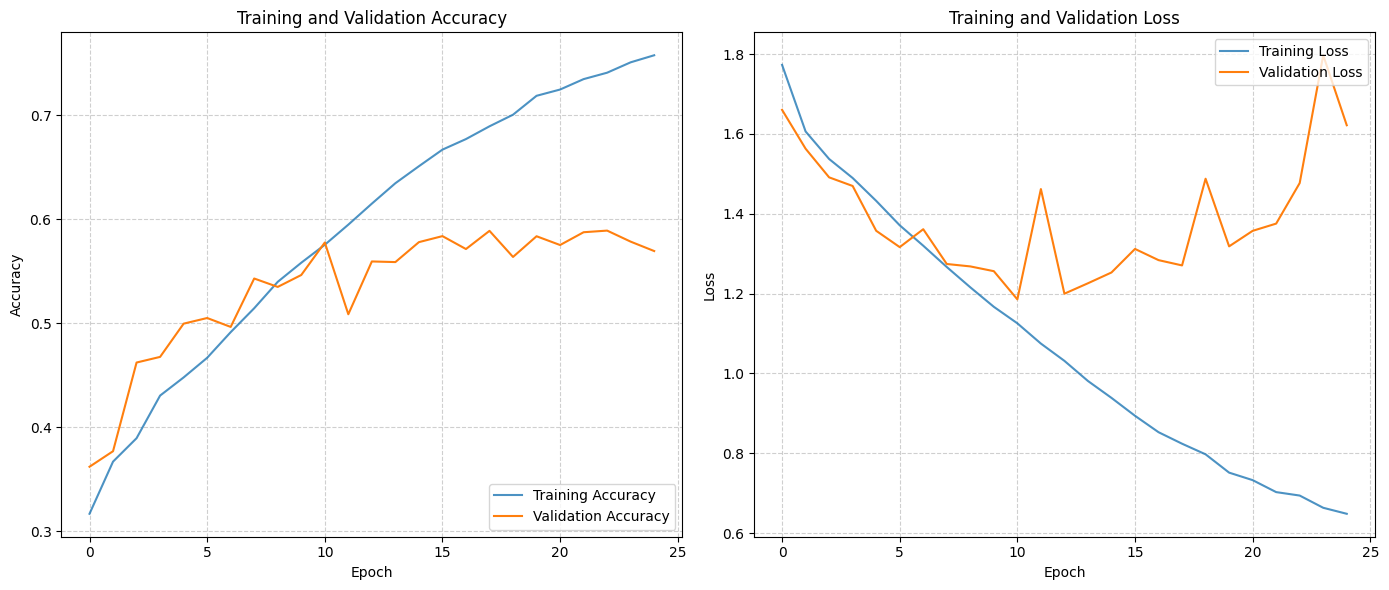

Best Validation Accuracy: 0.5891 at Epoch 23
Training Accuracy at Best Epoch: 0.7409
Training Loss at Best Epoch: 0.6942
Validation Loss at Best Epoch: 1.4770


In [12]:
#cell 5 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_ran = range(len(acc))  

plt.figure(figsize=(14, 6)) 

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs_ran, acc, label='Training Accuracy', alpha=0.8)
plt.plot(epochs_ran, val_acc, label='Validation Accuracy', linewidth=1.5)

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(epochs_ran, loss, label='Training Loss', alpha=0.8)
plt.plot(epochs_ran, val_loss, label='Validation Loss', linewidth=1.5)

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

directory = '/cluster/home/miolate21/FER_biasmitigation1/results'
filename = 'train_val_acc.png'
filepath = os.path.join(directory, filename)

plt.savefig(filepath)

plt.show()

best_epoch = np.argmax(val_acc)
print(f"Best Validation Accuracy: {val_acc[best_epoch]:.4f} at Epoch {best_epoch + 1}")
print(f"Training Accuracy at Best Epoch: {acc[best_epoch]:.4f}")
print(f"Training Loss at Best Epoch: {loss[best_epoch]:.4f}")
print(f"Validation Loss at Best Epoch: {val_loss[best_epoch]:.4f}")



/mounts/faraday/software/anaconda/envs/py312/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model loaded.
Loading validation images into memory...
Predicting...
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step

Classification Report:
              precision    recall  f1-score   support

       angry     0.5024    0.4361    0.4669       947
     disgust     0.4352    0.1958    0.2701       240
        fear     0.4354    0.1955    0.2698       880
       happy     0.8075    0.7994    0.8034      2408
     neutral     0.4552    0.6927    0.5494      1549
         sad     0.4811    0.4667    0.4738      1367
    surprise     0.6847    0.6840    0.6844       905

    accuracy                         0.5891      8296
   macro avg     0.5431    0.4957    0.5026      8296
weighted avg     0.5895    0.5891    0.5783      8296



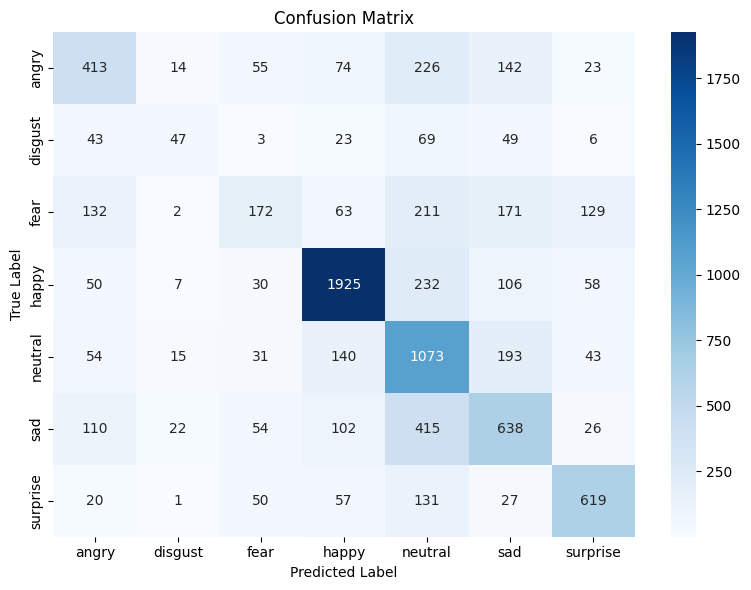

Classification report saved to: /cluster/home/miolate21/FER_biasmitigation1/results/classification_report_baseline_cnn48.txt


In [13]:
#cell 6 evaluate-report

# ====== Cell 6 (Updated) ======
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

MODEL_SAVE_PATH = '/cluster/home/miolate21/FER_biasmitigation1/models/cnn_baseline/baseline_cnn_48.keras'

try:
    model.load_weights(MODEL_SAVE_PATH)
except Exception as e:
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)

print("Model loaded.")

# Preload all validation images
print("Loading validation images into memory...")
val_images = np.array([np.load(p) for p in val_df['image_path'].values]).astype(np.float32)

if val_images.ndim == 3:
    val_images = np.expand_dims(val_images, axis=-1)

val_labels = val_df['label'].values

print("Predicting...")
y_pred_probs = model.predict(val_images, batch_size=64, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_labels

cm = confusion_matrix(y_true, y_pred)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('/cluster/home/miolate21/FER_biasmitigation1/results/baseline_confusion_matrix.png')
plt.show()

# Save classification report
report_text = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
filename = "classification_report_baseline_cnn48.txt"
report_path = os.path.join('/cluster/home/miolate21/FER_biasmitigation1/results', filename)

with open(report_path, 'w') as f:
    f.write(report_text)

print(f"Classification report saved to: {report_path}")

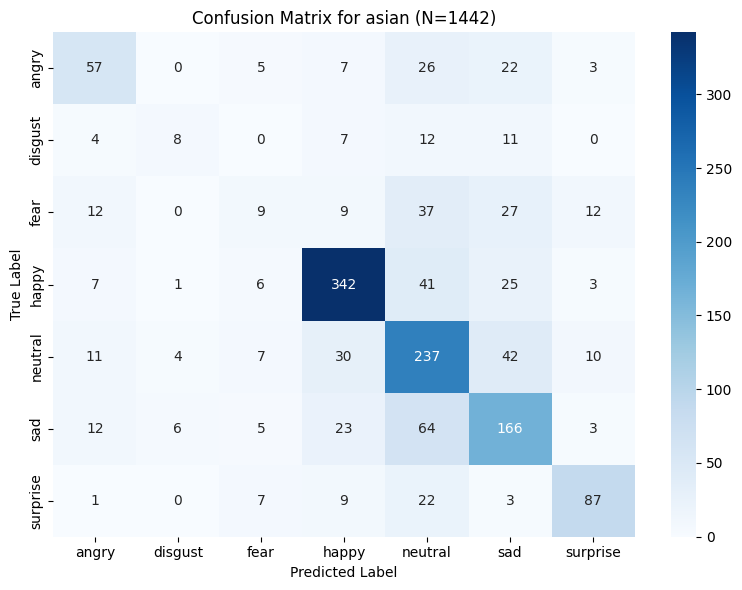

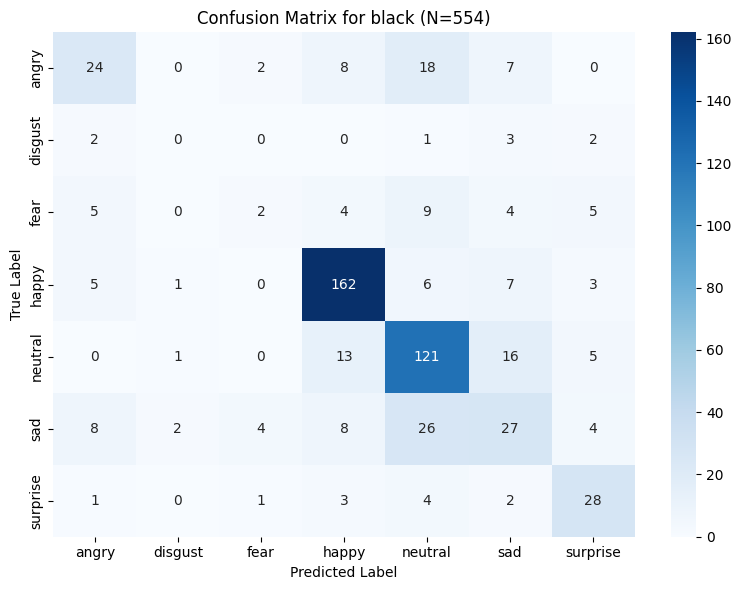

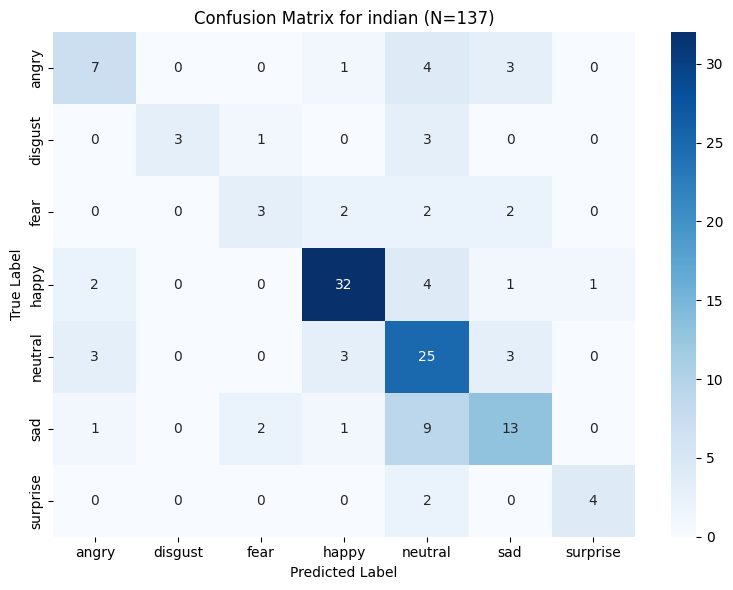

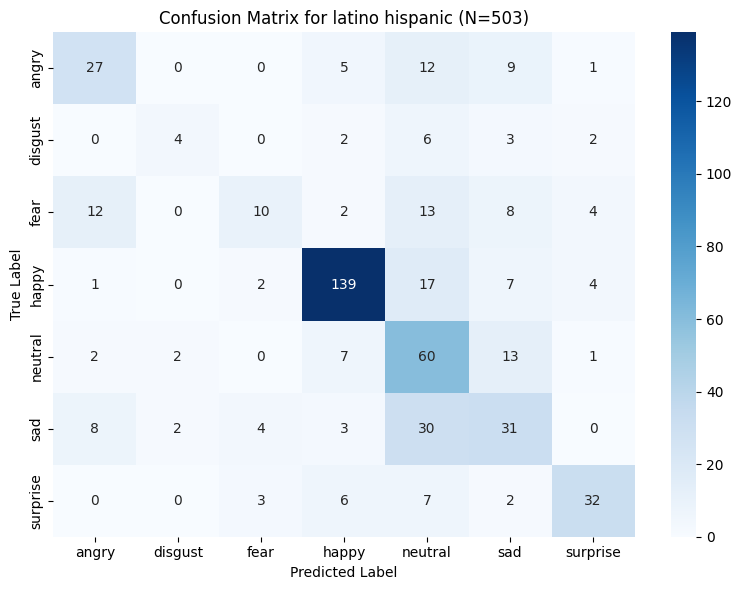

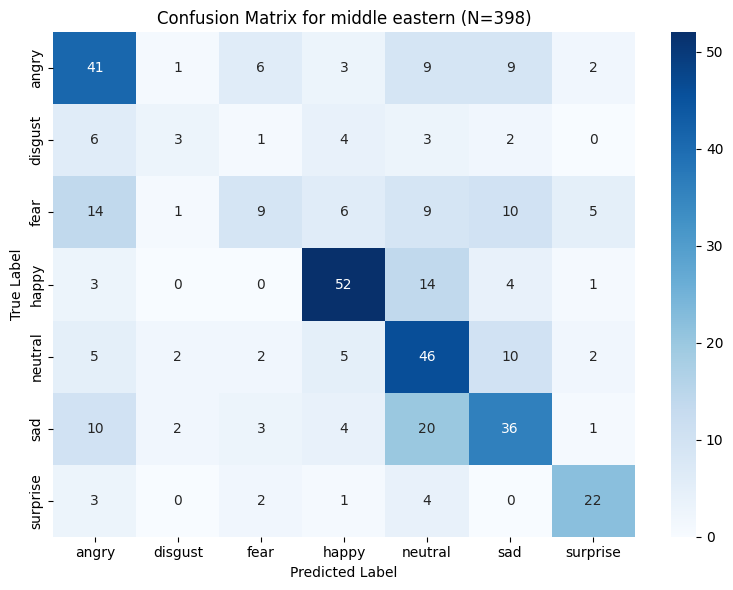

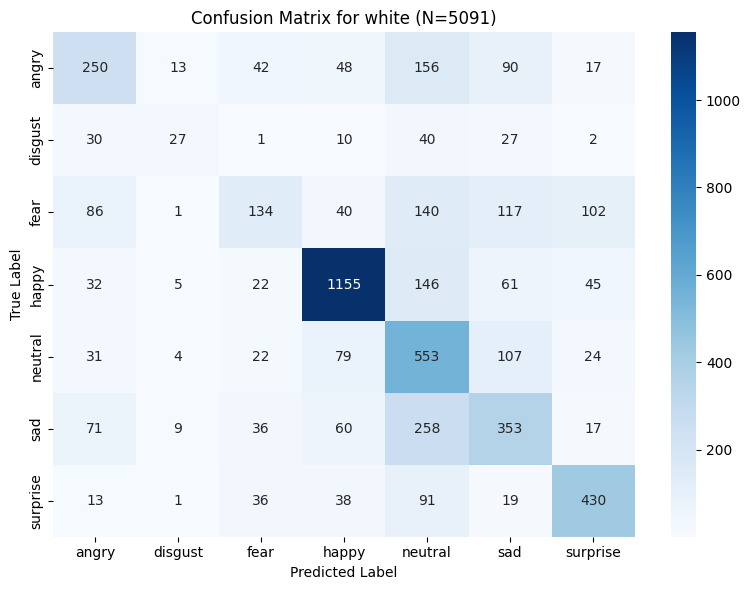

In [20]:
# cell 7
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

race_col = 'dominant_race' if 'dominant_race' in val_df.columns else 'race'

val_df_reset = val_df.reset_index(drop=True)

# Drop NaNs before getting unique races
unique_races = sorted(val_df_reset[race_col].dropna().unique())

for race in unique_races:
    race_mask = (val_df_reset[race_col] == race)
    y_true_race = y_true[race_mask]
    y_pred_race = y_pred[race_mask]

    if len(y_true_race) == 0:
        continue

    cm_race = confusion_matrix(y_true_race, y_pred_race, labels=list(range(len(CLASS_NAMES))))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_race, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix for {race} (N={len(y_true_race)})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [18]:
# cell 8
from sklearn.metrics import f1_score

print("Per-Race F1 Scores:")

race_f1_results = {}

unique_races = sorted(val_df_reset[race_col].dropna().unique())

for race in unique_races:
    race_mask = (val_df_reset[race_col] == race)
    y_true_race = y_true[race_mask]
    y_pred_race = y_pred[race_mask]

    if len(y_true_race) == 0:
        continue

    f1 = f1_score(y_true_race, y_pred_race, average='weighted')
    race_f1_results[race] = f1
    print(f"{race}: {f1:.4f}")

race_f1_df = pd.DataFrame(list(race_f1_results.items()), columns=['Race', 'Weighted_F1_Score'])
race_f1_df.to_csv('/cluster/home/miolate21/FER_biasmitigation1/results/race_f1_scores.csv', index=False)

print("\nSaved race F1 scores to: race_f1_scores.csv")

Per-Race F1 Scores:
asian: 0.6142
black: 0.6351
indian: 0.6324
latino hispanic: 0.5960
middle eastern: 0.5093
white: 0.5617

Saved race F1 scores to: race_f1_scores.csv
